# 实验四：朴素贝叶斯分类器
- 姓名：冯思程
- 学号：2112213
- 专业：计算机科学与技术

## 实验要求
### 截止日期：11月17日
以学号+姓名(4)的命名形式打包实验代码+实验报告，发送到邮箱2120230658@mail.nankai.edu.cn

### 数据集

Most Popular Data Set中的wine数据集（对意大利同一地区声场的三种不同品种的酒做大量分析所得出的数据）

### 基本要求：

采用分层采样的方式将数据集划分为训练集和测试集。 
给定编写一个朴素贝叶斯分类器，对测试集进行预测，计算分类准确率。
### 中级要求：

使用测试集评估模型，得到混淆矩阵，精度，召回率，F值。
### 高级要求：

在中级要求的基础上画出三类数据的ROC曲线，并求出AUC值。
### 拓展要求：

浅谈ROC曲线和AUC值作为分类评价的合理性。


=======================================================================================================================

# 开始

**环境**：python 3.10.9+vscode 1.82.2+一些必备的第三方库，例如numpy等。

<span style="color:red">**注意**</span>：我在后文的代码都补充了适当的注释并在代码前进行了适当注释和分析，感谢学长学姐的批阅！辛苦！

## 基础要求部分

观察发现这里的特征属性都是连续的，所以我假设其分布为高斯分布进行计算。具体计算公式如下：（这里我使用对数进行计算，让计算更加稳定。）

给定:
- \( X \) 为待分类样本的特征向量。
- $ \mu_k $ 为类别 \( k \) 的均值向量。
- $ \sigma_k^2 $ 为类别 \( k \) 的方差向量。
- \( n_k \) 为类别 \( k \) 中的样本数量。
- \( N \) 为所有类别中的总样本数量。
- \( K \) 为类别的总数。

对于每个类别 \( k \)，进行以下计算：

1. **先验概率的对数 (Log Prior):**
   $$
   \text{类别 } k \text{ 的先验概率的对数} = \log\left(\frac{n_k}{N}\right)
   $$

2. **似然概率的对数 (Log Likelihood):**
   $$
   \text{类别 } k \text{ 的似然概率的对数} = -\frac{1}{2} \sum\left(\log(2\pi\sigma_k^2) + \frac{(X - \mu_k)^2}{\sigma_k^2}\right)
   $$

3. **后验概率的对数 (Log Posterior):**
   $$
   \text{类别 } k \text{ 的后验概率的对数} = \text{类别 } k \text{ 的似然概率的对数} + \text{类别 } k \text{ 的先验概率的对数}
   $$

 在计算了每个类别的后验概率的对数之后，样本 \( X \) 的预测类别是后验概率的对数值最大的类别。

4. **预测:**
   $$
   \text{预测类别} = \arg\max_k(\text{类别 } k \text{ 的后验概率的对数})
   $$

每次预测类别与样本的实际类别不匹配时，错误预测的数量会增加。



### 导入需要的包

In [66]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

### 数据读取

In [67]:
# 定义特征列名
column_names = [
    'Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium',
    'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
    'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline'
]

# 读取数据，第一列是类别，后13列是特征列
df = pd.read_csv('./wine.data', header=None, names=column_names)
print(df)

     Class  Alcohol  Malic acid   Ash  Alcalinity of ash  Magnesium  \
0        1    14.23        1.71  2.43               15.6        127   
1        1    13.20        1.78  2.14               11.2        100   
2        1    13.16        2.36  2.67               18.6        101   
3        1    14.37        1.95  2.50               16.8        113   
4        1    13.24        2.59  2.87               21.0        118   
..     ...      ...         ...   ...                ...        ...   
173      3    13.71        5.65  2.45               20.5         95   
174      3    13.40        3.91  2.48               23.0        102   
175      3    13.27        4.28  2.26               20.0        120   
176      3    13.17        2.59  2.37               20.0        120   
177      3    14.13        4.10  2.74               24.5         96   

     Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  \
0             2.80        3.06                  0.28             2.29   
1

### 构建贝叶斯分类器并进行预测

In [68]:
# 实现贝叶斯分类器
# train_data和test_data应该是字典格式，其中键是类别标签，值是对应的数据样本。
# 数据样本被存储为NumPy数组。
def bayes_classify(train_data, test_data):
    means = {}
    std = {}
    wrong_num = 0
    predictions = []

    score=[]
    # 对每个类别计算均值和标准差，跳过第一列
    for cls in train_data:
        cls_data = np.array(train_data[cls])[:, 1:]
        means[cls] = np.mean(cls_data, axis=0)
        std[cls] = np.std(cls_data, ddof=1, axis=0)

    # 分类测试数据
    for cls in test_data:
        for sample in test_data[cls]:
            # 跳过第一列
            sample_features = sample[1:] 

            log_likelihoods = []
            for cls_train in train_data:
                # 计算每个测试样本不同类别的后验概率的对数
                log_likelihood = -0.5 * np.sum(np.log(2 * math.pi * std[cls_train] ** 2))
                log_likelihood -= 0.5 * np.sum(((sample_features - means[cls_train]) ** 2) / (std[cls_train] ** 2))
                prior = math.log(len(train_data[cls_train]) / sum(len(samples) for samples in train_data.values()))
                log_likelihoods.append(log_likelihood + prior)
            # 将每个测试样本的三类得分都存起来后面需要用
            score.append(log_likelihoods)
            # 预测类别
            predicted_cls = np.argmax(log_likelihoods)+1
            predictions.append(predicted_cls)

            # 如果预测错误，增加错误数
            if predicted_cls != cls:
                wrong_num += 1
    return wrong_num, predictions,score


采用十折交叉验证+分层抽样来进行验证分类器效果。

In [69]:
# 按照类别划分数据集，这里转化成了字典，方便后续调用
class_groups = df.groupby('Class')
stratified_data = {cls: data.values for cls, data in class_groups}

accuracies = []

totalpre=[]
totalright=[]
totalscore=[]
for i in range(10):
    train_data = {cls: [] for cls in stratified_data}
    test_data = {cls: [] for cls in stratified_data}
    y_test = []

    # 分层划分数据集
    for cls, group in stratified_data.items():
        group_length = len(group)
        test_len = round(group_length / 10)# 我让其四舍五入，可以更均衡地划分数据集
        test_start = i * test_len
        test_end = (i + 1) * test_len if i != 10 - 1 else group_length
        test_data[cls] = group[test_start:test_end]
        train_data[cls] = np.concatenate((group[:test_start], group[test_end:]), axis=0)
        y_test.extend([cls] * len(test_data[cls]))
    # 数据带入朴素贝叶斯分类器
    wrong_num, predictions ,score= bayes_classify(train_data, test_data)
    totalpre.append(predictions)
    totalright.append(y_test)
    # 存得分列表，在高级要求中需要用到
    totalscore.append(score)
    # 计算此轮准确率
    testsize=len(test_data[1])+len(test_data[2])+len(test_data[3])
    fold_accuracy = (testsize - wrong_num) / testsize
    accuracies.append(fold_accuracy)
    print(f"Fold {i + 1}: Accuracy = {fold_accuracy:.4f}")

# 输出平均准确率
average_accuracy = sum(accuracies) / 10
print(f"平均准确率： {average_accuracy:.4f}")

Fold 1: Accuracy = 0.9444
Fold 2: Accuracy = 1.0000
Fold 3: Accuracy = 1.0000
Fold 4: Accuracy = 0.9444
Fold 5: Accuracy = 0.9444
Fold 6: Accuracy = 1.0000
Fold 7: Accuracy = 1.0000
Fold 8: Accuracy = 0.9444
Fold 9: Accuracy = 1.0000
Fold 10: Accuracy = 1.0000
平均准确率： 0.9778


## 中级要求部分

使用测试集评估模型，得到混淆矩阵，精度，召回率，F值。

上文我已经把正确的类别标签存在了totalright中，而且把每折的预测结果存在了totalpre中，下面就可以利用这两个进行计算。

![计算公式](https://i.imgur.com/FjGLJwc.png)



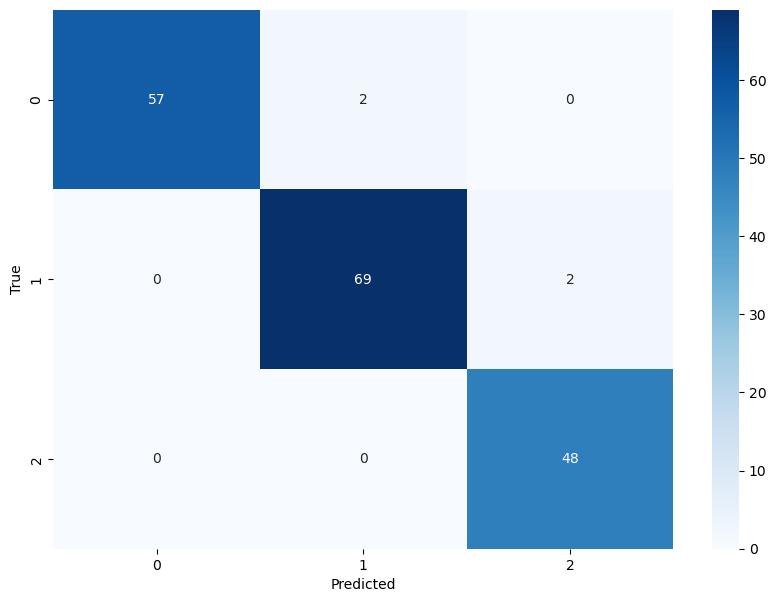

class     precision recall    f1-score  support   
1         1.0000    0.9661    0.9828    59        
2         0.9718    0.9718    0.9718    71        
3         0.9600    1.0000    0.9796    48        
macro avg 0.9773    0.9793    0.9783    178       
总体准确率     0.9775    


In [70]:
def calculate(true_labels, predicted_labels):
    flat_true = [label for sublist in true_labels for label in sublist]
    flat_predicted = [label for sublist in predicted_labels for label in sublist]
    
    num_classes = len(sorted(set(flat_true)))
    confusion_matrix = [[0 for _ in range(num_classes)] for _ in range(num_classes)]
    
    # 这里直接利用预测标签和真实标签直接填充混淆矩阵
    for t, p in zip(flat_true, flat_predicted):
        confusion_matrix[t - 1][p - 1] += 1
    # 后续直接利用混淆矩阵来计算各种指标
    precision = []
    recall = []
    # 计算精度和召回率
    for i in range(num_classes):
        TP = confusion_matrix[i][i]
        FP = sum(confusion_matrix[j][i] for j in range(num_classes) if j != i)
        FN = sum(confusion_matrix[i][j] for j in range(num_classes) if j != i)
        
        prec = TP / (TP + FP) if (TP + FP) > 0 else 0
        rec = TP / (TP + FN) if (TP + FN) > 0 else 0

        precision.append(prec)
        recall.append(rec)
    
    # 计算F1分数
    f1_scores = [2 * p * r / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]
    
    # 计算总体准确率
    overall_accuracy = sum(confusion_matrix[i][i] for i in range(num_classes)) / len(flat_true)
    # 计算各类个数
    support = [flat_true.count(i) for i in range(1, num_classes+1)]
    return {
        'confusion_matrix': confusion_matrix,
        'precision': precision,
        'recall': recall,
        'f1_scores': f1_scores,
        'overall_accuracy': overall_accuracy,
        'support':support
    }# 返回一个字典


result = calculate(totalright, totalpre)
# 画出混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(result['confusion_matrix'], annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 打印结果
print(f"{'class':<10}{'precision':<10}{'recall':<10}{'f1-score':<10}{'support':<10}")
for i, (prec, rec, f1, supp) in enumerate(zip(result['precision'], result['recall'], result['f1_scores'], result['support']), 1):
    print(f"{i:<10}{prec:<10.4f}{rec:<10.4f}{f1:<10.4f}{supp:<10}")

# 计算平均值
macro_precision = sum(result['precision']) / df.iloc[:, 0].nunique()
macro_recall = sum(result['recall']) / df.iloc[:, 0].nunique()
macro_f1 = 2 * macro_precision * macro_recall / (macro_precision+macro_recall)
total_support = sum(result['support'])

print(f"{'macro avg':<10}{macro_precision:<10.4f}{macro_recall:<10.4f}{macro_f1:<10.4f}{total_support:<10}")
print(f"{'总体准确率':<10}{result['overall_accuracy']:<10.4f}")

## 高级要求部分



In [71]:
# 这里是用简单的梯形原理进行计算auc值，也就是计算曲线的面积
def calculate_auc(fprs, tprs):
    sorted_points = sorted(zip(fprs, tprs))
    sorted_fprs, sorted_tprs = zip(*sorted_points)
    auc = 0.0
    for i in range(1, len(sorted_fprs)):
        auc += (sorted_fprs[i] - sorted_fprs[i-1]) * (sorted_tprs[i] + sorted_tprs[i-1]) / 2
    return abs(auc)

def calculate_and_plot_roc(true_labels, predicted_scores, num_classes):
    curve_points = {}
    aucs = {}
    # 对于每个类别，计算ROC曲线
    for c in range(num_classes):
        thresholds = [tup[c] for tup in predicted_scores]# 阈值的选取对于每个类的计算是取对应的类别的得分作为阈值。
        tprs = []
        fprs = []
        for threshold in thresholds:
            TP = FP = FN = TN = 0
            for i, score in enumerate(predicted_scores):
                # 真实标签为当前类别
                if true_labels[i] == c+1:
                    if score[c] >= threshold:
                        TP += 1
                    else:
                        FN += 1
                # 真实标签不是当前类别
                else:
                    if score[c] >= threshold:
                        FP += 1
                    else:
                        TN += 1
            tpr = TP / (TP + FN) if (TP + FN) else 0
            fpr = FP / (FP + TN) if (FP + TN) else 0
            tprs.append(tpr)
            fprs.append(fpr)
        curve_points[c] = (fprs, tprs)
        #print(fprs)
        #print(tprs)
        aucs[c] = calculate_auc(fprs, tprs)


    # 绘制ROC曲线，auc已经写在对应曲线的图标上
    plt.figure(figsize=(8, 6))
    for c, (fprs, tprs) in curve_points.items():
        plt.plot(sorted(fprs), sorted(tprs), label=f'Class {c} (AUC = {aucs[c]:.2f})')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--')  # 画出随机性能线作为参考，黑色虚线
    plt.legend(loc='lower right')
    plt.show()

    

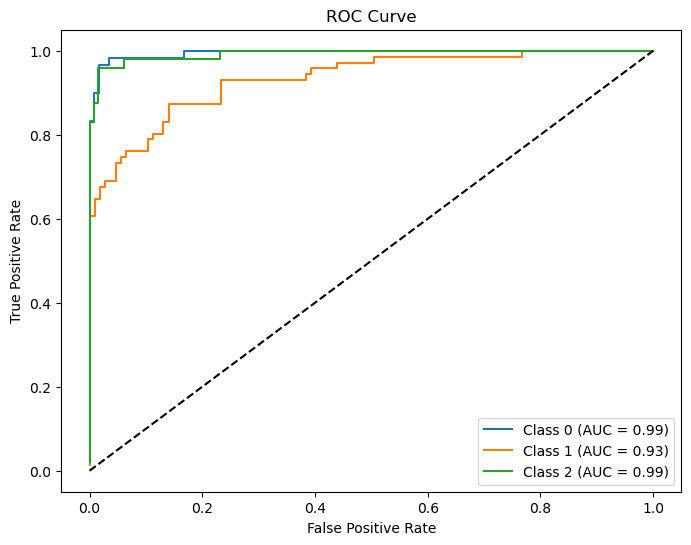

In [72]:
scoreuse = [element for sublist in totalscore for element in sublist]
rightuse = [label for sublist in totalright for label in sublist]

calculate_and_plot_roc(rightuse,scoreuse,df.iloc[:, 0].nunique())




## 扩展要求

浅谈ROC曲线和AUC值作为分类评价的合理性。

**答**：
- 简介：ROC曲线（Receiver Operating Characteristic curve）和AUC值（Area Under the ROC Curve）是评估分类模型性能的重要工具，它们在多类分类问题中也可以通过一对一或一对多的策略被应用（如本次的三分类问题）。
- ROC曲线的合理性：
性能全面性：ROC曲线提供了在不同阈值设置下模型性能的全面图景，它展示了随着分类阈值的变化，真正类率（TPR）和假正类率（FPR）之间的关系；**阈值不依赖**：ROC曲线的一个关键优点是它不依赖于类别分布或决策阈值，使其在类分布不平衡时仍然有效；易于比较：不同模型的ROC曲线可以在同一图表中绘制和比较。模型的曲线越接近左上角，性能越好。（如上图，三条线都是接近左上角的。）
- AUC值的合理性：
量化性能：AUC值为ROC曲线下的面积，提供了一个量化的性能指标。AUC值为1表示完美的分类器，而0.5表示无效的分类器（相当于随机猜测，参考上图中的黑色虚线）；平衡性：AUC值考虑了分类器对于正类和负类的分类能力，因此它是一个平衡的指标，既考虑了召回率也考虑了假正率；比较简便：AUC为单一数值，非常适合于比较不同模型的性能或进行模型选择。